# 1. Загрузка данных и библиотек

In [301]:
import numpy as np
import kagglehub
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as skm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

In [302]:
path = kagglehub.dataset_download("sujithmandala/credit-score-classification-dataset")

In [303]:
print("Path to dataset files:", path)

Path to dataset files: /home/rustam/.cache/kagglehub/datasets/sujithmandala/credit-score-classification-dataset/versions/1


In [304]:
data = pd.read_csv(path+'/Credit Score Classification Dataset.csv')

In [305]:
data

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High
...,...,...,...,...,...,...,...,...
159,29,Female,27500,High School Diploma,Single,0,Rented,Low
160,34,Male,47500,Associate's Degree,Single,0,Rented,Average
161,39,Female,62500,Bachelor's Degree,Married,2,Owned,High
162,44,Male,87500,Master's Degree,Single,0,Owned,High


# 2. Первичный анализ данных 

## 2.1 Анализ набора данных

In [345]:
data.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


In [346]:
data.describe()

,Age,Income,Number of Children
count,164.000000,164.000000,164.000000
mean,37.975610,83765.243902,0.652439
std,8.477289,32457.306728,0.883346
min,25.000000,25000.000000,0.000000
25%,30.750000,57500.000000,0.000000
50%,37.000000,83750.000000,0.000000
75%,45.000000,105000.000000,1.000000
max,53.000000,162500.000000,3.000000


In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 164 non-null    int64 
 1   Gender              164 non-null    object
 2   Income              164 non-null    int64 
 3   Education           164 non-null    object
 4   Marital Status      164 non-null    object
 5   Number of Children  164 non-null    int64 
 6   Home Ownership      164 non-null    object
 7   Credit Score        164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB


In [348]:
data.describe(include='object')

,Gender,Education,Marital Status,Home Ownership,Credit Score
count,164,164,164,164,164
unique,2,5,2,2,3
top,Female,Bachelor's Degree,Married,Owned,High
freq,86,42,87,111,113


## 2.2 Гипотезы


1) Средний возраст хороших заёмщиков выше, чем у остальных
2) Люди с лучшим образованием имеет более высокий доход
3) Семейные люди с детьми имеют лучший рейтинг, чем холостяки

### Гипотеза 1

In [349]:
print('Средний возраст заёмщиков с высоким рейтингом = ', data[data['Credit Score'] == 'High']['Age'].mean())
print('Средний возраст заёмщиков с средним рейтингом = ', data[data['Credit Score'] == 'Average']['Age'].mean())
print('Средний возраст заёмщиков с низким рейтингом = ', data[data['Credit Score'] == 'Low']['Age'].mean())

Средний возраст заёмщиков с высоким рейтингом =  41.991150442477874
Средний возраст заёмщиков с средним рейтингом =  29.52777777777778
Средний возраст заёмщиков с низким рейтингом =  28.0


<Axes: xlabel='Credit Score'>

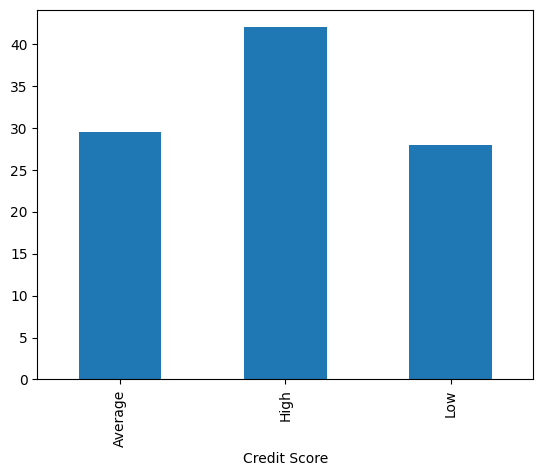

In [350]:
data.groupby(['Credit Score'])['Age'].mean().plot(kind='bar', rot=90)

Гипотеза подтвердилась. Действительно более взрослые люди имеют лучший кредитный рейтинг.

### Гипотеза 2

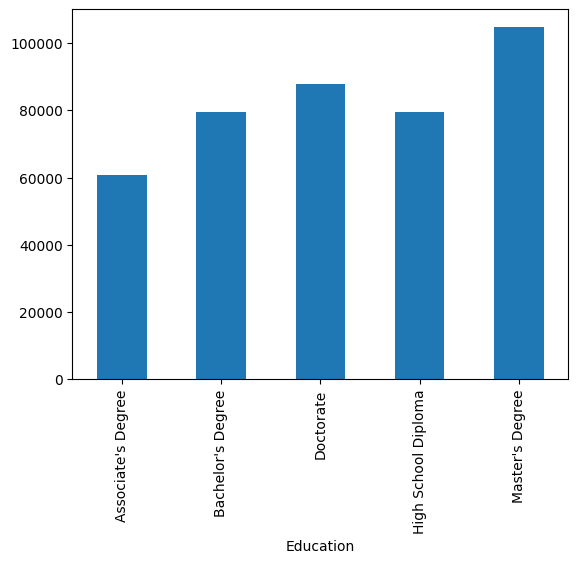

In [351]:
mean_income_by_education = data.groupby(['Education'])['Income'].mean().plot(kind='bar', rot=90)

Гипотеза не подтвердилась. Согласно данным, наибольшим доходом обладают магистры. 

### Гипотеза 3

In [352]:
print('high score percent of married persons with children = ', data[(data['Number of Children'] > 0) & (data['Marital Status'] == 'Married')& (data['Credit Score'] == 'High')].shape[0] / data.shape[0])
print('single person high score = ', data[(data['Marital Status'] == 'Single')& (data['Credit Score'] == 'High')].shape[0] / data.shape[0])

high score percent of married persons with children =  0.39634146341463417
single person high score =  0.17073170731707318


Гипотеза справедлива

# 3 Подготовка данных

In [314]:
data.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


In [315]:
gender_dict = {'Female':0, 'Male': 1}
martial_status = {'Single': 0, 'Married': 1}
home = {'Rented': 0, 'Owned': 1}

In [316]:
data_processed =  data.copy()

In [317]:
data_processed['Gender'] = data_processed['Gender'].map(gender_dict)

In [318]:
data_processed['Marital Status'] = data_processed['Marital Status'].map(martial_status)

In [319]:
data_processed['Home Ownership'] = data_processed['Home Ownership'].map(home) 

In [320]:
data_processed = pd.concat( [data_processed, pd.get_dummies(data_processed['Education']) * 1], axis=1)

In [321]:
data_processed

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score,Associate's Degree,Bachelor's Degree,Doctorate,High School Diploma,Master's Degree
0,25,0,50000,Bachelor's Degree,0,0,0,High,0,1,0,0,0
1,30,1,100000,Master's Degree,1,2,1,High,0,0,0,0,1
2,35,0,75000,Doctorate,1,1,1,High,0,0,1,0,0
3,40,1,125000,High School Diploma,0,0,1,High,0,0,0,1,0
4,45,0,100000,Bachelor's Degree,1,3,1,High,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,29,0,27500,High School Diploma,0,0,0,Low,0,0,0,1,0
160,34,1,47500,Associate's Degree,0,0,0,Average,1,0,0,0,0
161,39,0,62500,Bachelor's Degree,1,2,1,High,0,1,0,0,0
162,44,1,87500,Master's Degree,0,0,1,High,0,0,0,0,1


In [322]:
data_processed.drop(['Education'], axis=1, inplace=True)

In [323]:
data_processed

,Age,Gender,Income,Marital Status,Number of Children,Home Ownership,Credit Score,Associate's Degree,Bachelor's Degree,Doctorate,High School Diploma,Master's Degree
0,25,0,50000,0,0,0,High,0,1,0,0,0
1,30,1,100000,1,2,1,High,0,0,0,0,1
2,35,0,75000,1,1,1,High,0,0,1,0,0
3,40,1,125000,0,0,1,High,0,0,0,1,0
4,45,0,100000,1,3,1,High,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
159,29,0,27500,0,0,0,Low,0,0,0,1,0
160,34,1,47500,0,0,0,Average,1,0,0,0,0
161,39,0,62500,1,2,1,High,0,1,0,0,0
162,44,1,87500,0,0,1,High,0,0,0,0,1


In [324]:
X = data_processed.drop(['Credit Score'], axis=1)
Y = data_processed['Credit Score']

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [326]:
scaler = MinMaxScaler().fit(X_train)

In [327]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 4 Regression

In [328]:
clf_regress = OneVsRestClassifier(LogisticRegression())

In [329]:
clf_regress.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [330]:
pred_train = clf_regress.predict(X_train)

## Проверка результатов на тренировочных данных

In [331]:
print(metrics.accuracy_score(y_train, pred_train))

0.9465648854961832


In [332]:
confusion_matrix = skm.multilabel_confusion_matrix(y_train, pred_train)
print(confusion_matrix)
print(skm.classification_report(y_train, pred_train))

[[[ 97   5]
  [  2  27]]

 [[ 39   2]
  [  2  88]]

 [[119   0]
  [  3   9]]]
              precision    recall  f1-score   support

     Average       0.84      0.93      0.89        29
        High       0.98      0.98      0.98        90
         Low       1.00      0.75      0.86        12

    accuracy                           0.95       131
   macro avg       0.94      0.89      0.91       131
weighted avg       0.95      0.95      0.95       131



## Проверка результатов на отложенной выборке

In [333]:
pred_test = clf_regress.predict(X_test)

In [334]:
pred_test

array(['Average', 'Average', 'Average', 'High', 'Average', 'High', 'High',
       'High', 'High', 'High', 'Average', 'High', 'High', 'High', 'High',
       'High', 'High', 'High', 'High', 'Low', 'Average', 'Average',
       'High', 'High', 'High', 'High', 'High', 'Average', 'High',
       'Average', 'High', 'High', 'High'], dtype='<U7')

In [335]:
print(metrics.accuracy_score(y_test, pred_test))

0.9393939393939394


In [336]:
confusion_matrix = skm.multilabel_confusion_matrix(y_test, pred_test)
print(confusion_matrix)
print(skm.classification_report(y_test, pred_test))

[[[24  2]
  [ 0  7]]

 [[10  0]
  [ 0 23]]

 [[30  0]
  [ 2  1]]]
              precision    recall  f1-score   support

     Average       0.78      1.00      0.88         7
        High       1.00      1.00      1.00        23
         Low       1.00      0.33      0.50         3

    accuracy                           0.94        33
   macro avg       0.93      0.78      0.79        33
weighted avg       0.95      0.94      0.93        33



# 5 Deciosion tree

In [337]:
clf_tree = DecisionTreeClassifier()

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [339]:
parameters = {'max_depth':range(3,10)}

In [340]:
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4)

In [341]:
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.9772079772079773 {'max_depth': 4}


## Проверка результатов на отложенной выборке

In [342]:
pred_test = tree_model.predict(X_test)

In [343]:
confusion_matrix = skm.multilabel_confusion_matrix(y_test, pred_test)
print(confusion_matrix)
print(skm.classification_report(y_test, pred_test))

[[[25  1]
  [ 0  7]]

 [[10  0]
  [ 1 22]]

 [[30  0]
  [ 0  3]]]
              precision    recall  f1-score   support

     Average       0.88      1.00      0.93         7
        High       1.00      0.96      0.98        23
         Low       1.00      1.00      1.00         3

    accuracy                           0.97        33
   macro avg       0.96      0.99      0.97        33
weighted avg       0.97      0.97      0.97        33



[Text(0.5, 0.9, 'Home Ownership <= 0.5\ngini = 0.471\nsamples = 131\nvalue = [29, 90, 12]\nclass = Average'),
 Text(0.25, 0.7, 'Income <= 38750.0\ngini = 0.5\nsamples = 42\nvalue = [27.0, 3.0, 12.0]\nclass = High'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'gini = 0.0\nsamples = 12\nvalue = [0, 0, 12]\nclass = Low'),
 Text(0.375, 0.5, 'Income <= 85000.0\ngini = 0.18\nsamples = 30\nvalue = [27, 3, 0]\nclass = High'),
 Text(0.25, 0.3, 'Age <= 25.5\ngini = 0.069\nsamples = 28\nvalue = [27, 1, 0]\nclass = High'),
 Text(0.125, 0.1, 'gini = 0.198\nsamples = 9\nvalue = [8, 1, 0]\nclass = High'),
 Text(0.375, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [19, 0, 0]\nclass = High'),
 Text(0.5, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]\nclass = Average'),
 Text(0.75, 0.7, 'Age <= 29.5\ngini = 0.044\nsamples = 89\nvalue = [2, 87, 0]\nclass = Average'),
 Text(0.625, 0.8, '  False'),
 Text(0.625, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]\nclass = High'),
 Text(0.875, 0.5, 'gini = 0.0\

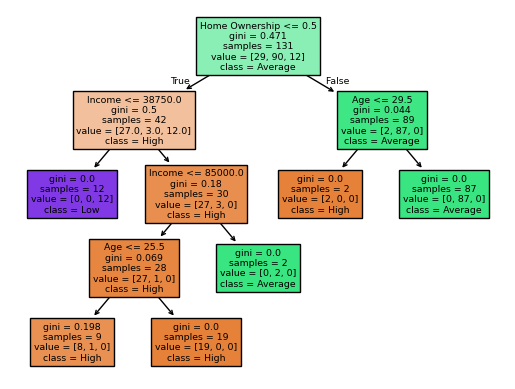

In [344]:
plot_tree(tree_model, feature_names=data_processed.columns, filled=True, class_names=['High', 'Average', 'Low'])